In [43]:
!pip uninstall --yes pyopenssl
!pip install pyopenssl

Found existing installation: pyOpenSSL 24.1.0
Uninstalling pyOpenSSL-24.1.0:
  Successfully uninstalled pyOpenSSL-24.1.0
  Using cached pyOpenSSL-24.1.0-py3-none-any.whl.metadata (12 kB)
Using cached pyOpenSSL-24.1.0-py3-none-any.whl (56 kB)


In [44]:
# @title Colab Setup and Imports { display-mode: "form" }
# @markdown (double click to see the code)

import os
import random

import git
import numpy as np
from gym import spaces

%matplotlib inline
from matplotlib import pyplot as plt

repo = git.Repo(".", search_parent_directories=True)
dir_path = repo.working_tree_dir
data_path = os.path.join(dir_path, "habitat/data")
os.chdir(dir_path)

from PIL import Image

import habitat
from habitat.core.logging import logger
from habitat.core.registry import registry
from habitat.sims.habitat_simulator.actions import HabitatSimActions
from habitat.tasks.nav.nav import NavigationTask
from habitat_baselines.common.baseline_registry import baseline_registry
from habitat_baselines.config.default import get_config as get_baselines_config

In [45]:
!python -m habitat_sim.utils.datasets_download --uids mp3d_example_scene --data-path {data_path} --no-replace

Existing data source (mp3d_example_scene) version (1.1) is current. Data located: '/home/david/Desktop/EPFL/comm_proj/com304-go2/habitat/data/versioned_data/mp3d_example_scene_1.1'. Symblink: '/home/david/Desktop/EPFL/comm_proj/com304-go2/habitat/data/scene_datasets/mp3d_example'.
Not replacing data, generating symlink (/home/david/Desktop/EPFL/comm_proj/com304-go2/habitat/data/scene_datasets/mp3d_example).
Generating symlink (/home/david/Desktop/EPFL/comm_proj/com304-go2/habitat/data/scene_datasets/mp3d_example).


In [46]:
# @title Define Observation Display Utility Function { display-mode: "form" }

# @markdown A convenient function that displays sensor observations with matplotlib.

# @markdown (double click to see the code)


# Change to do something like this maybe: https://stackoverflow.com/a/41432704
def display_sample(
    rgb_obs, semantic_obs=np.array([]), depth_obs=np.array([])
):  # noqa: B006
    from habitat_sim.utils.common import d3_40_colors_rgb

    rgb_img = Image.fromarray(rgb_obs, mode="RGB")

    arr = [rgb_img]
    titles = ["rgb"]
    if semantic_obs.size != 0:
        semantic_img = Image.new(
            "P", (semantic_obs.shape[1], semantic_obs.shape[0])
        )
        semantic_img.putpalette(d3_40_colors_rgb.flatten())
        semantic_img.putdata((semantic_obs.flatten() % 40).astype(np.uint8))
        semantic_img = semantic_img.convert("RGBA")
        arr.append(semantic_img)
        titles.append("semantic")

    if depth_obs.size != 0:
        depth_img = Image.fromarray(
            (depth_obs / 10 * 255).astype(np.uint8), mode="L"
        )
        arr.append(depth_img)
        titles.append("depth")

    plt.figure(figsize=(12, 8))
    for i, data in enumerate(arr):
        ax = plt.subplot(1, 3, i + 1)
        ax.axis("off")
        ax.set_title(titles[i])
        plt.imshow(data)
    plt.show(block=False)

## Setup PointNav Task

In [56]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        ),
        overrides=[
            "habitat.environment.max_episode_steps=10",
            "habitat.environment.iterator_options.shuffle=False",
            "habitat.dataset.data_path=habitat/data/datasets/pointnav/habitat-test-scenes/v1/test/test.json.gz",
            "habitat.dataset.scenes_dir=habitat/data/scene_datasets"
        ],
    )
    try:
        env.close()  # type: ignore[has-type]
    except NameError:
        pass
    env = habitat.Env(config=config)

2024-04-23 21:01:19,819 Initializing dataset PointNav-v1
2024-04-23 21:01:19,824 initializing sim Sim-v0
2024-04-23 21:01:20,659 Initializing task Nav-v0


Renderer: NVIDIA GeForce RTX 3050 Ti Laptop GPU/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.54.15
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


[21:01:19:834256]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[21:01:19:834438]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: Filehabitat/data/scene_datasets/habitat-test-scenes/skokloster-castle.scndoes not exist.  Aborting load.
[21:01:19:834453]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `habitat/data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `habitat/data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
[21:01:19:834462]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `habitat/data/scene_datasets/habitat-test-scenes/skokl

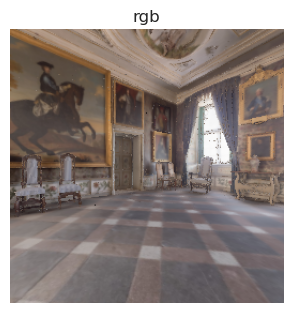

distance to goal: 5.64
angle to goal (radians): 2.88


In [57]:
    action = None
    obs = env.reset()
    valid_actions = ["turn_left", "turn_right", "move_forward", "stop"]
    interactive_control = False  # @param {type:"boolean"}
    while action != "stop":
        display_sample(obs["rgb"])
        print(
            "distance to goal: {:.2f}".format(
                obs["pointgoal_with_gps_compass"][0]
            )
        )
        print(
            "angle to goal (radians): {:.2f}".format(
                obs["pointgoal_with_gps_compass"][1]
            )
        )
        if interactive_control:
            action = input(
                "enter action out of {}:\n".format(", ".join(valid_actions))
            )
            assert (
                action in valid_actions
            ), "invalid action {} entered, choose one amongst " + ",".join(
                valid_actions
            )
        else:
            action = valid_actions.pop()
        obs = env.step(
            {
                "action": action,
            }
        )

    env.close()

In [58]:
    print(env.get_metrics())

{'distance_to_goal': 6.335183143615723, 'success': 0.0, 'spl': 0.0, 'distance_to_goal_reward': -0.0}


## RL Training

In [59]:
if __name__ == "__main__":
    config = get_baselines_config("pointnav/ppo_pointnav_example.yaml")

In [64]:
# set random seeds
if __name__ == "__main__":
    seed = "42"  # @param {type:"string"}
    steps_in_thousands = "10"  # @param {type:"string"}

    with habitat.config.read_write(config):
        config.habitat.seed = int(seed)
        config.habitat_baselines.total_num_steps = int(steps_in_thousands)
        config.habitat_baselines.log_interval = 1
        config.habitat.dataset.scenes_dir="habitat/data/scene_datasets"
        config.habitat.dataset.data_path="habitat/data/datasets/pointnav/habitat-test-scenes/v1/test/test.json.gz"

    random.seed(config.habitat.seed)
    np.random.seed(config.habitat.seed)

In [65]:
if __name__ == "__main__":
    trainer_init = baseline_registry.get_trainer(
        config.habitat_baselines.trainer_name
    )
    trainer = trainer_init(config)
    trainer.train()

2024-04-23 21:04:18,686 config: habitat:
  seed: 42
  env_task: GymHabitatEnv
  env_task_gym_dependencies: []
  env_task_gym_id: ''
  environment:
    max_episode_steps: 500
    max_episode_seconds: 10000000
    iterator_options:
      cycle: true
      shuffle: true
      group_by_scene: true
      num_episode_sample: -1
      max_scene_repeat_episodes: -1
      max_scene_repeat_steps: 10000
      step_repetition_range: 0.2
  simulator:
    type: Sim-v0
    forward_step_size: 0.25
    turn_angle: 10
    create_renderer: false
    requires_textures: true
    auto_sleep: false
    step_physics: true
    concur_render: false
    needs_markers: true
    update_articulated_agent: true
    scene: data/scene_datasets/habitat-test-scenes/van-gogh-room.glb
    scene_dataset: default
    additional_object_paths: []
    seed: ${habitat.seed}
    default_agent_id: 0
    debug_render: false
    debug_render_articulated_agent: false
    kinematic_mode: false
    should_setup_semantic_ids: true
    

pybullet build time: Apr 18 2024 19:50:43
Renderer: NVIDIA GeForce RTX 3050 Ti Laptop GPU/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.54.15
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-b

[21:04:22:033987]:[Warning]:[Sim] Simulator.cpp(594)::instanceStageForSceneAttributes : The active scene does not contain semantic annotations : activeSemanticSceneID_ = 0
2024-04-23 21:04:22,036 Initializing task Nav-v0
2024-04-23 21:04:22,511 Number of params to train: 5821797
2024-04-23 21:04:22,512 Agent number of parameters: 5821797
2024-04-23 21:04:23,480 update: 1	fps: 33.694	
2024-04-23 21:04:23,481 Num updates: 1	Num frames 32
2024-04-23 21:04:23,481 Average window size: 1  distance_to_goal: 10.440  distance_to_goal_reward: 0.000  reward: 0.046  spl: 0.000  success: 0.000
2024-04-23 21:04:23,481 	Perf Stats: trainer.rollout_collect: 0.598 trainer.sample_action: 0.014 trainer.obs_insert: 0.000 trainer.step_env: 0.004 trainer.update_stats: 0.000 trainer.update_agent: 0.348


In [66]:
# @markdown (double click to see the code)

# example tensorboard visualization
# for more details refer to [link](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-baselines/habitat_baselines#additional-utilities).

try:
    from IPython import display

    with open("./res/img/tensorboard_video_demo.gif", "rb") as f:
        display.display(display.Image(data=f.read(), format="png"))
except ImportError:
    pass

FileNotFoundError: [Errno 2] No such file or directory: './res/img/tensorboard_video_demo.gif'

## Key Concepts

All the concepts link to their definitions:

1. [`habitat.sims.habitat_simulator.HabitatSim`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/sims/habitat_simulator/habitat_simulator.py#L254)
Thin wrapper over `habitat_sim` providing seamless integration with experimentation framework.


2. [`habitat.core.env.Env`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/env.py#L26)
Abstraction for the universe of agent, task and simulator. Agents that you train and evaluate operate inside the environment.


3. [`habitat.core.env.RLEnv`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/env.py#L347)
Extends the `Env` class for reinforcement learning by defining the reward and other required components.


4. [`habitat.core.embodied_task.EmbodiedTask`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/embodied_task.py#L201)
Defines the task that the agent needs to solve. This class holds the definition of observation space, action space, measures, simulator usage. Eg: PointNav, ObjectNav.


5. [`habitat.core.dataset.Dataset`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/dataset.py#L107)
Wrapper over information required for the dataset of embodied task, contains definition and interaction with an `episode`.


6. [`habitat.core.embodied_task.Measure`](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/core/embodied_task.py#L80)
Defines the metrics for embodied task, eg: [SPL](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/tasks/nav/nav.py#L565).


7. [`habitat_baselines`](https://github.com/facebookresearch/habitat-lab/tree/main/habitat-baselines/habitat_baselines)
RL, SLAM, heuristic baseline implementations for the different embodied tasks.

## Create a new Task

In [74]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        ),
        overrides=[
            "habitat.environment.max_episode_steps=10",
            "habitat.environment.iterator_options.shuffle=False",
            "habitat.dataset.data_path=habitat/data/datasets/pointnav/habitat-test-scenes/v1/test/test.json.gz",
            "habitat.dataset.scenes_dir=habitat/data/scene_datasets",
        ],
    )


@registry.register_task(name="TestNav-v0")
class NewNavigationTask(NavigationTask):
    def __init__(self, config, sim, dataset):
        logger.info("Creating a new type of task")
        super().__init__(config=config, sim=sim, dataset=dataset)

    def _check_episode_is_active(self, *args, **kwargs):
        logger.info(
            "Current agent position: {}".format(self._sim.get_agent_state())
        )
        collision = self._sim.previous_step_collided
        stop_called = not getattr(self, "is_stop_called", False)
        return collision or stop_called


if __name__ == "__main__":
    with habitat.config.read_write(config):
        config.habitat.task.type = "TestNav-v0"

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

2024-04-23 21:18:52,554 Initializing dataset PointNav-v1
2024-04-23 21:18:52,560 initializing sim Sim-v0


{'type': 'PointNav-v1', 'split': 'train', 'scenes_dir': 'habitat/data/scene_datasets', 'content_scenes': ['*'], 'data_path': 'habitat/data/datasets/pointnav/habitat-test-scenes/v1/test/test.json.gz'}


[21:18:52:571146]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[21:18:52:571523]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: Filehabitat/data/scene_datasets/habitat-test-scenes/skokloster-castle.scndoes not exist.  Aborting load.
[21:18:52:571537]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `habitat/data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `habitat/data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
[21:18:52:571544]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `habitat/data/scene_datasets/habitat-test-scenes/skokl

Renderer: NVIDIA GeForce RTX 3050 Ti Laptop GPU/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.54.15
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


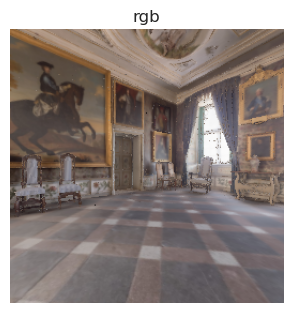

2024-04-23 21:19:20,100 Current agent position: AgentState(position=array([-1.2676634 ,  0.20478529, 12.5954275 ], dtype=float32), rotation=quaternion(0.891185760498047, 0, 0.45363849401474, 0), sensor_states={'rgb': SixDOFPose(position=array([-1.2676634,  1.4547853, 12.5954275], dtype=float32), rotation=quaternion(0.891185760498047, 0, 0.45363849401474, 0)), 'depth': SixDOFPose(position=array([-1.2676634,  1.4547853, 12.5954275], dtype=float32), rotation=quaternion(0.891185760498047, 0, 0.45363849401474, 0))})


Episode over: True


In [75]:
    action = None
    env.reset()
    valid_actions = ["turn_left", "turn_right", "move_forward", "stop"]
    interactive_control = False  # @param {type:"boolean"}
    while env.episode_over is not True:
        display_sample(obs["rgb"])
        if interactive_control:
            action = input(
                "enter action out of {}:\n".format(", ".join(valid_actions))
            )
            assert (
                action in valid_actions
            ), "invalid action {} entered, choose one amongst " + ",".join(
                valid_actions
            )
        else:
            action = valid_actions.pop()
        obs = env.step(
            {
                "action": action,
                "action_args": None,
            }
        )
        print("Episode over:", env.episode_over)

    env.close()

## Create a new Sensor

In [76]:
@registry.register_sensor(name="agent_position_sensor")
class AgentPositionSensor(habitat.Sensor):
    def __init__(self, sim, config, **kwargs):
        super().__init__(config=config)
        self._sim = sim

    # Defines the name of the sensor in the sensor suite dictionary
    def _get_uuid(self, *args, **kwargs):
        return "agent_position"

    # Defines the type of the sensor
    def _get_sensor_type(self, *args, **kwargs):
        return habitat.SensorTypes.POSITION

    # Defines the size and range of the observations of the sensor
    def _get_observation_space(self, *args, **kwargs):
        return spaces.Box(
            low=np.finfo(np.float32).min,
            high=np.finfo(np.float32).max,
            shape=(3,),
            dtype=np.float32,
        )

    # This is called whenever reset is called or an action is taken
    def get_observation(self, observations, *args, episode, **kwargs):
        return self._sim.get_agent_state().position

In [79]:
if __name__ == "__main__":
    config = habitat.get_config(
        config_path=os.path.join(
            dir_path,
            "habitat/config/benchmark/nav/pointnav/pointnav_habitat_test.yaml",
        ),
        overrides=[
            "habitat.environment.max_episode_steps=10",
            "habitat.environment.iterator_options.shuffle=False",
            "habitat.dataset.data_path=habitat/data/datasets/pointnav/habitat-test-scenes/v1/test/test.json.gz",
            "habitat.dataset.scenes_dir=habitat/data/scene_datasets",
        ],
    )

    from habitat.config.default_structured_configs import LabSensorConfig

    # We use the base sensor config, but you could also define your own
    # AgentPositionSensorConfig that inherits from LabSensorConfig

    with habitat.config.read_write(config):
        # Now define the config for the sensor
        config.habitat.task.lab_sensors[
            "agent_position_sensor"
        ] = LabSensorConfig(type="agent_position_sensor")

    try:
        env.close()
    except NameError:
        pass
    env = habitat.Env(config=config)

2024-04-23 21:19:44,263 Initializing dataset PointNav-v1
2024-04-23 21:19:44,268 initializing sim Sim-v0
2024-04-23 21:19:45,446 Initializing task Nav-v0


Renderer: NVIDIA GeForce RTX 3050 Ti Laptop GPU/PCIe/SSE2 by NVIDIA Corporation
OpenGL version: 4.6.0 NVIDIA 550.54.15
Using optional features:
    GL_ARB_vertex_array_object
    GL_ARB_separate_shader_objects
    GL_ARB_robustness
    GL_ARB_texture_storage
    GL_ARB_texture_view
    GL_ARB_framebuffer_no_attachments
    GL_ARB_invalidate_subdata
    GL_ARB_texture_storage_multisample
    GL_ARB_multi_bind
    GL_ARB_direct_state_access
    GL_ARB_get_texture_sub_image
    GL_ARB_texture_filter_anisotropic
    GL_KHR_debug
    GL_KHR_parallel_shader_compile
    GL_NV_depth_buffer_float
Using driver workarounds:
    no-forward-compatible-core-context
    nv-egl-incorrect-gl11-function-pointers
    no-layout-qualifiers-on-old-glsl
    nv-zero-context-profile-mask
    nv-implementation-color-read-format-dsa-broken
    nv-cubemap-inconsistent-compressed-image-size
    nv-cubemap-broken-full-compressed-image-query
    nv-compressed-block-size-in-bits


[21:19:44:277427]:[Warning]:[Metadata] SceneDatasetAttributes.cpp(107)::addNewSceneInstanceToDataset : Dataset : 'default' : Lighting Layout Attributes 'no_lights' specified in Scene Attributes but does not exist in dataset, so creating default.
[21:19:44:278044]:[Warning]:[Scene] SemanticScene.h(328)::checkFileExists : ::loadSemanticSceneDescriptor: Filehabitat/data/scene_datasets/habitat-test-scenes/skokloster-castle.scndoes not exist.  Aborting load.
[21:19:44:278085]:[Warning]:[Scene] SemanticScene.cpp(121)::loadSemanticSceneDescriptor : SSD File Naming Issue! Neither SemanticAttributes-provided name : `habitat/data/scene_datasets/habitat-test-scenes/skokloster-castle.scn` nor constructed filename : `habitat/data/scene_datasets/habitat-test-scenes/info_semantic.json` exist on disk.
[21:19:44:278102]:[Error]:[Scene] SemanticScene.cpp(137)::loadSemanticSceneDescriptor : SSD Load Failure! File with SemanticAttributes-provided name `habitat/data/scene_datasets/habitat-test-scenes/skokl

In [80]:
    obs = env.reset()

In [81]:
    obs.keys()

dict_keys(['rgb', 'depth', 'pointgoal_with_gps_compass', 'agent_position'])

In [82]:
    print(obs["agent_position"])

[-1.2676634   0.20478529 12.5954275 ]


In [83]:
    env.close()

## Create a new Agent

In [84]:
# An example agent which can be submitted to habitat-challenge.
# To participate and for more details refer to:
# - https://aihabitat.org/challenge/2020/
# - https://github.com/facebookresearch/habitat-challenge


class ForwardOnlyAgent(habitat.Agent):
    def __init__(self, success_distance, goal_sensor_uuid):
        self.dist_threshold_to_stop = success_distance
        self.goal_sensor_uuid = goal_sensor_uuid

    def reset(self):
        pass

    def is_goal_reached(self, observations):
        dist = observations[self.goal_sensor_uuid][0]
        return dist <= self.dist_threshold_to_stop

    def act(self, observations):
        if self.is_goal_reached(observations):
            action = HabitatSimActions.stop
        else:
            action = HabitatSimActions.move_forward
        return {"action": action}

### Other Examples

[Create a new action space](https://github.com/facebookresearch/habitat-lab/blob/main/examples/new_actions.py)

In [85]:
# @title Sim2Real with Habitat { display-mode: "form" }

try:
    from IPython.display import HTML

    HTML(
        '<iframe width="560" height="315" src="https://www.youtube.com/embed/Hun2rhgnWLU" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>'
    )
except ImportError:
    pass

/home/david/anaconda3/envs/habitat/lib/python3.9/site-packages/IPython/core/display.py:431: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


Deploy habitat-sim trained models on real robots with the [habitat-pyrobot bridge](https://github.com/facebookresearch/habitat-lab/blob/main/habitat-lab/habitat/sims/pyrobot/pyrobot.py)

```python
# Are we in sim or reality?
if args.use_robot: # Use LoCoBot via PyRobot
    config.habitat.simulator.type = "PyRobot-Locobot-v0"
else: # Use simulation
    config.habitat.simulator.type = "Habitat-Sim-v0"
```

Paper: [https://arxiv.org/abs/1912.06321](https://arxiv.org/abs/1912.06321)